<a href="https://colab.research.google.com/github/guifav/calls_analyzer/blob/main/2_analise_consolidada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parte 2 de 2 - Análise Consolidada

## Para mais informações e tutoriais

Site do autor: [www.guilhermefavaron.com.br](https://www.guilhermefavaron.com.br)

O projeto completo pode ser acessado no github: [https://github.com/guifav/calls_analyzer](https://github.com/guifav/calls_analyzer)

O Diretório de arquivos e pastas deve estar organizado conforme abaixo:

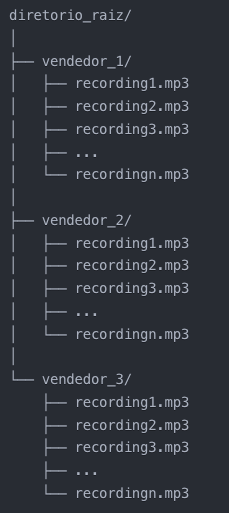

# Instalando recursos necessários

In [16]:
# Instalando biblioteca Openai
!pip install openai

In [17]:
import openai

# Importar secret keys
from google.colab import userdata

# Retrieve the API key
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

# Configurar o cliente OpenAI
client = OpenAI(api_key=OPENAI_API_KEY)

# Análise gráfica dos resultados

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Tentando abrir: /content/drive/MyDrive/ai_gui/jose_silva/jose_silva_transcriptions.json
Leitura do arquivo: /content/drive/MyDrive/ai_gui/jose_silva/jose_silva_transcriptions.json
Tentando abrir: /content/drive/MyDrive/ai_gui/luciano_pavarosi/luciano_pavarosi_transcriptions.json
Leitura do arquivo: /content/drive/MyDrive/ai_gui/luciano_pavarosi/luciano_pavarosi_transcriptions.json
Tentando abrir: /content/drive/MyDrive/ai_gui/carmelo_morais/carmelo_morais_transcriptions.json
Leitura do arquivo: /content/drive/MyDrive/ai_gui/carmelo_morais/carmelo_morais_transcriptions.json


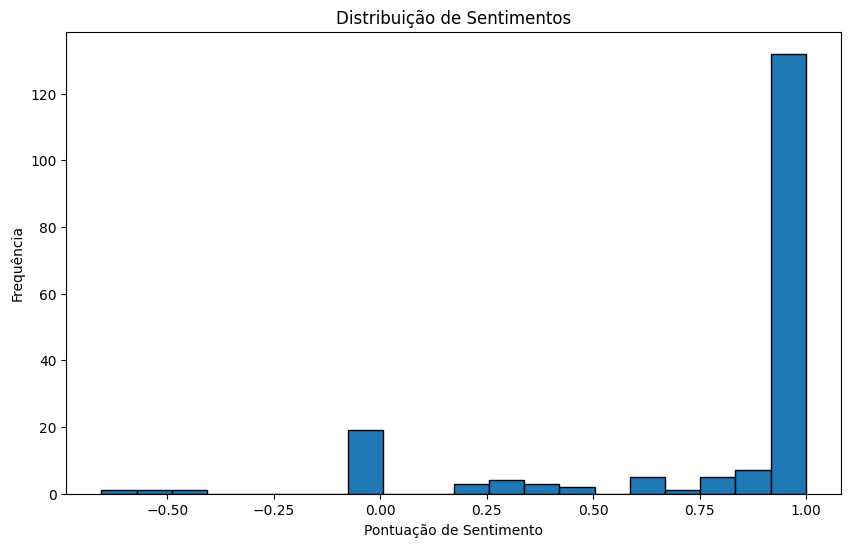

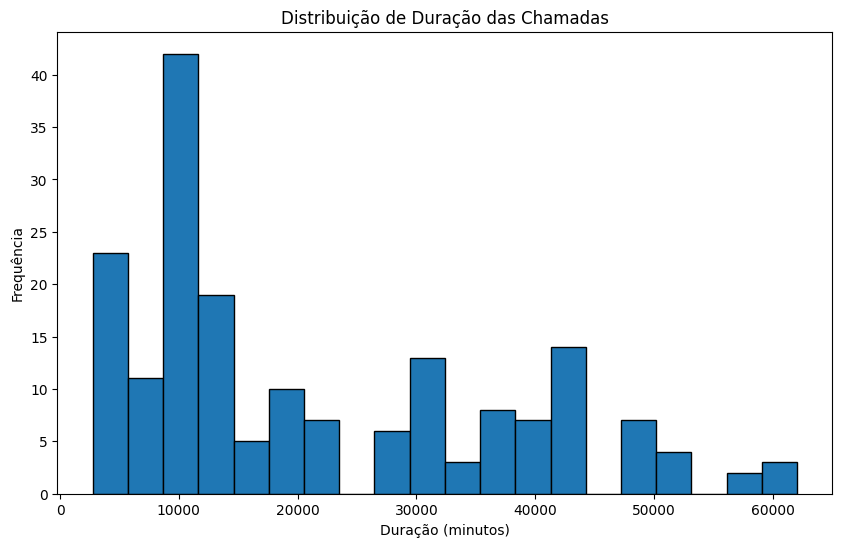

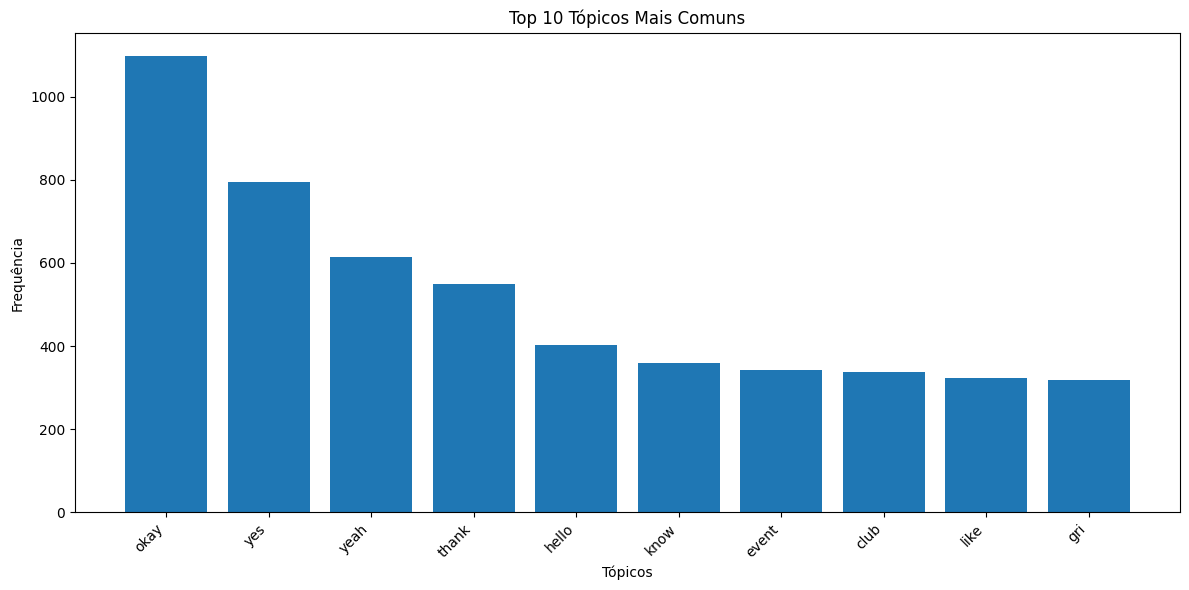

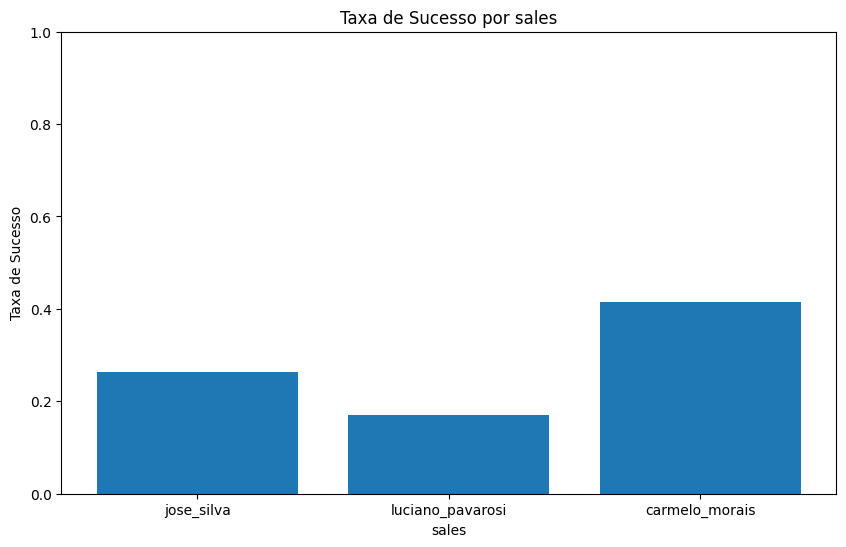

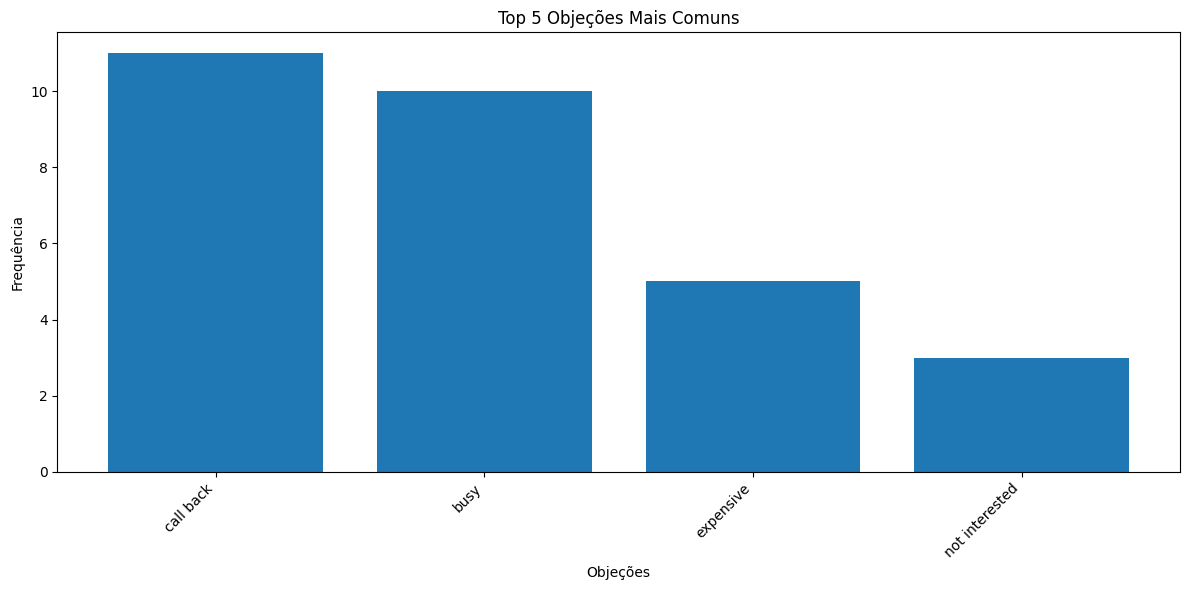

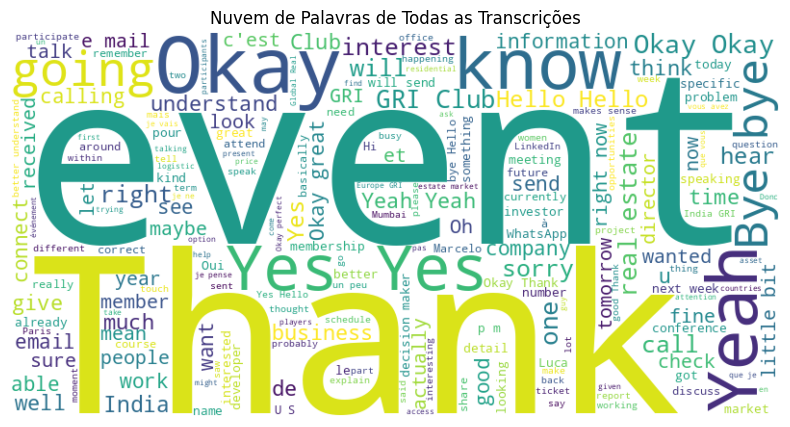

Resultados numéricos:
sentiment_scores:
  [0.9975, 0.9993, 0.9998, 0.9955, 0.9925, 0.9765, 0.9984, 0.9939, 0.9997, 0.9981, 0.0, 0.9937, 0.9961, 0.9971, 0.9992, 0.9639, 0.9992, 0.9997, 0.9761, 0.9946, 0.9882, 0.9999, 0.9829, 0.9984, 0.9999, 0.9703, 0.9998, 0.9999, 0.8645, 0.9989, 0.952, 0.9528, 1.0, 0.9714, 0.9927, 0.9714, 0.9929, 0.9697, 0.997, 0.9995, 0.9995, 0.9746, 0.9924, 0.8225, 0.4696, 0.9447, 0.6597, 0.9989, 0.9971, 0.2131, 0.2131, 0.0, 0.6508, 0.0, 0.5881, 0.9989, 0.9984, 0.9996, 0.9953, 0.8702, 0.9695, -0.6553, 0.9996, 0.9999, 0.9897, 0.9901, 0.9743, 0.9996, 0.9997, 0.8446, 0.9903, 0.9997, 0.9364, 0.0, 0.0, 0.0, 0.6199, -0.4696, 0.0, 0.4137, 0.0, 0.9378, 0.2732, 0.0, 0.4939, 0.0, 0.0, 0.7882, 0.9356, 0.2869, 0.9349, 0.9988, 0.9997, 0.9153, 0.8707, 0.3182, 0.0, 0.9898, 0.9993, 0.9971, 0.9201, 0.0, 0.998, 0.9928, 0.0, 0.9924, 0.9393, 0.9971, 0.9976, 0.9963, 0.8738, 0.9864, 0.9996, 0.6424, 0.9874, 0.9937, 0.9929, 0.9999, 0.9429, 0.9607, 0.9932, 0.9788, 0.9966, 0.9936, 0.9873, 0.9

In [18]:
import json
import re
from collections import Counter
from datetime import datetime
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Download dos recursos necessários do NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Função para carregar os dados JSON
def load_json_data(sales_name):
    sales_name = sales_name.replace('_transcriptions.json', '')
    file_path = f'/content/drive/MyDrive/ai_gui/{sales_name}/{sales_name}_transcriptions.json'
    print(f"Tentando abrir: {file_path}")
    with open(file_path, 'r', encoding='utf-8') as file:
        print(f"Leitura do arquivo: {file_path}")
        return json.load(file)

# Função para análise de sentimento
def analyze_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)['compound']

# Função para extrair tópicos
def extract_topics(text):
    words = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    return [word for word in words if word.isalnum() and word not in stop_words]

# Função para calcular a duração da chamada
def calculate_call_duration(timestamp):
    call_time = datetime.strptime(timestamp.split('_')[0], "%Y-%m-%dT%H-%M-%S")
    return (datetime.now() - call_time).total_seconds() / 60  # duração em minutos

# Função para verificar o sucesso da chamada
def check_success(text):
    success_keywords = ['schedule', 'interested', 'follow up', 'next steps']
    return any(keyword in text.lower() for keyword in success_keywords)

# Função para identificar objeções
def identify_objections(text):
    objection_keywords = ['expensive', 'not interested', 'busy', 'call back', 'no budget']
    return [keyword for keyword in objection_keywords if keyword in text.lower()]

# Função para extrair palavras-chave
def extract_keywords(text, n=10):
    words = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    keywords = [word for word in words if word.isalnum() and word not in stop_words]
    return Counter(keywords).most_common(n)

# Função para criar nuvem de palavras
def create_word_cloud(data):
    all_text = ' '.join([transcript for sales_data in data.values() for transcript in sales_data.values()])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nuvem de Palavras de Todas as Transcrições')
    plt.show()

# Funções de análise

def analyze_sentiment_distribution(data):
    sentiments = [analyze_sentiment(transcript) for sales_data in data.values() for transcript in sales_data.values()]
    plt.figure(figsize=(10, 6))
    plt.hist(sentiments, bins=20, edgecolor='black')
    plt.title('Distribuição de Sentimentos')
    plt.xlabel('Pontuação de Sentimento')
    plt.ylabel('Frequência')
    plt.show()

def analyze_call_durations(data):
    durations = [calculate_call_duration(call_id) for sales_data in data.values() for call_id in sales_data.keys()]
    plt.figure(figsize=(10, 6))
    plt.hist(durations, bins=20, edgecolor='black')
    plt.title('Distribuição de Duração das Chamadas')
    plt.xlabel('Duração (minutos)')
    plt.ylabel('Frequência')
    plt.show()

def analyze_topics(data):
    all_topics = [topic for sales_data in data.values() for transcript in sales_data.values() for topic in extract_topics(transcript)]
    topic_counts = Counter(all_topics).most_common(10)
    topics, counts = zip(*topic_counts)
    plt.figure(figsize=(12, 6))
    plt.bar(topics, counts)
    plt.title('Top 10 Tópicos Mais Comuns')
    plt.xlabel('Tópicos')
    plt.ylabel('Frequência')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def analyze_success_rate(data):
    success_rates = {sales: sum(check_success(transcript) for transcript in transcripts.values()) / len(transcripts)
                     for sales, transcripts in data.items()}
    plt.figure(figsize=(10, 6))
    plt.bar(success_rates.keys(), success_rates.values())
    plt.title('Taxa de Sucesso por sales')
    plt.xlabel('sales')
    plt.ylabel('Taxa de Sucesso')
    plt.ylim(0, 1)
    plt.show()

def analyze_common_objections(data):
    all_objections = [objection for sales_data in data.values() for transcript in sales_data.values() for objection in identify_objections(transcript)]
    objection_counts = Counter(all_objections).most_common(5)
    objections, counts = zip(*objection_counts)
    plt.figure(figsize=(12, 6))
    plt.bar(objections, counts)
    plt.title('Top 5 Objeções Mais Comuns')
    plt.xlabel('Objeções')
    plt.ylabel('Frequência')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Função principal de análise
def analyze_transcriptions(data):
    analyze_sentiment_distribution(data)
    analyze_call_durations(data)
    analyze_topics(data)
    analyze_success_rate(data)
    analyze_common_objections(data)
    create_word_cloud(data)

    results = {
        'sentiment_scores': [analyze_sentiment(transcript) for sales_data in data.values() for transcript in sales_data.values()],
        'call_durations': [calculate_call_duration(call_id) for sales_data in data.values() for call_id in sales_data.keys()],
        'topics': Counter([topic for sales_data in data.values() for transcript in sales_data.values() for topic in extract_topics(transcript)]),
        'success_rate': {sales: sum(check_success(transcript) for transcript in transcripts.values()) / len(transcripts) for sales, transcripts in data.items()},
        'common_objections': Counter([objection for sales_data in data.values() for transcript in sales_data.values() for objection in identify_objections(transcript)]),
    }

    return results

# Carregamento dos dados
jose_silva_data = load_json_data('jose_silva')
luciano_pavarosi_data = load_json_data('luciano_pavarosi')
carmelo_morais_data = load_json_data('carmelo_morais')

all_data = {
    'jose_silva': jose_silva_data,
    'luciano_pavarosi': luciano_pavarosi_data,
    'carmelo_morais': carmelo_morais_data
}

# Execução da análise
results = analyze_transcriptions(all_data)

# Impressão dos resultados numéricos
print("Resultados numéricos:")
for key, value in results.items():
    print(f"{key}:")
    if isinstance(value, dict):
        for sub_key, sub_value in value.items():
            print(f"  {sub_key}: {sub_value}")
    elif isinstance(value, Counter):
        for item, count in value.most_common(10):
            print(f"  {item}: {count}")
    else:
        print(f"  {value}")

# Análises individuais

In [20]:
import json
import os
from openai import OpenAI
from google.colab import drive

# Function to load JSON data
def load_json_data(sales_name):
    sales_name = sales_name.replace('_transcriptions.json', '')
    file_path = f'/content/drive/MyDrive/ai_gui/{sales_name}/{sales_name}_transcriptions.json'
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

# Function to analyze JSON file using OpenAI
def analyze_json(json_data):
    """

    Args:
      json_data:

    Returns:

    """
    # Convert JSON to a formatted string
    json_str = json.dumps(json_data, indent=2)

    prompt = f"""
    Analise o seguinte arquivo JSON contendo transcrições de ligações de representantes de desenvolvimento de vendas (sales)

    {json_str}

    Por favor, forneça insights sobre:
    Nuvem de palavras-chave relacionadas à venda: Identifique e liste as palavras-chave mais frequentes e relevantes que aparecem nas transcrições e que estão relacionadas ao processo de venda.
    Principais objeções: Destaque as objeções mais comuns levantadas pelos clientes durante as ligações, fornecendo exemplos específicos quando possível.
    Padrões positivos nas ligações: Identifique padrões ou práticas positivas que contribuíram para o sucesso das ligações, como técnicas de persuasão eficazes, frases que geraram interesse ou respostas positivas dos clientes.
    Padrões negativos nas ligações: Detecte padrões ou práticas negativas que possam estar prejudicando o desempenho das ligações, como respostas inadequadas, falhas de comunicação ou falta de preparação.
    Treinamentos sugeridos para desenvolvimento do sales: Com base nos padrões observados, sugira treinamentos ou áreas de desenvolvimento que podem ajudar os saless a melhorar seu desempenho, fornecendo exemplos práticos de como esses treinamentos poderiam ser aplicados.

    Seja específico e forneça exemplos do JSON sempre que possível.
    """

    response = client.chat.completions.create(
        model="chatgpt-4o-latest",
        messages=[
            {"role": "system", "content": "You are an expert data analyst specializing in sales performance data."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=4000
    )

    return response.choices[0].message.content

# Load and analyze data for each sales
saless = ['jose_silva', 'luciano_pavarosi', 'carmelo_morais']

for sales in saless:
    print(f"\nAnalyzing JSON file for {sales}:")
    json_data = load_json_data(sales)
    analysis = analyze_json(json_data)
    print(analysis)
    print("-" * 50)

# Note: This script will make API calls to OpenAI for each JSON file,
# which may take some time and consume API credits.


Analyzing JSON file for jose_silva:
**1. Nuvem de palavras-chave relacionadas à venda:**

A análise das transcrições revelou várias palavras-chave frequentes e relevantes que estão relacionadas ao processo de venda. As mais frequentes incluem:

- **Networking** – Frequentemente mencionada como o principal interesse dos participantes ao participar dos eventos, conforme Sushant mencionou: "o evento é para networking, certo?"
- **Event/Evento** – Grande parte das conversas gira em torno dos eventos que a GRI Club organiza, com clientes perguntando sobre detalhes como localização, datas e tópicos do evento.
- **GRI Club** – A marca é mencionada em todas as ligações, indicando que muitos leads e clientes buscam informações sobre a organização ou já têm algum conhecimento prévio.
- **Developer/Desenvolvedor** – Muitas empresas e prospects parecem estar diretamente envolvidas com desenvolvimento, seja residencial ou comercial, como mencionado por Ketan: "I have my own boutique investment ban

KeyboardInterrupt: 

# Análises combinadas

In [22]:
import json
import os
from openai import OpenAI
from google.colab import drive

# Function to load JSON data
def load_json_data(sales_name):
    sales_name = sales_name.replace('_transcriptions.json', '')
    file_path = f'/content/drive/MyDrive/ai_gui/{sales_name}/{sales_name}_transcriptions.json'
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

# Function to analyze JSON file using OpenAI
def analyze_json(json_data):
    # Convert JSON to a formatted string
    json_str = json.dumps(json_data, indent=2)

    prompt = f"""
    Analise o seguinte arquivo JSON contendo transcrições de ligações de representantes de desenvolvimento de vendas (saless)

    {json_str}

    Por favor, forneça insights sobre:
    Nuvem de palavras-chave relacionadas à venda: Identifique e liste as palavras-chave mais frequentes e relevantes que aparecem nas transcrições e que estão relacionadas ao processo de venda.
    Principais objeções: Destaque as objeções mais comuns levantadas pelos clientes durante as ligações, fornecendo exemplos específicos quando possível.
    Padrões positivos nas ligações: Identifique padrões ou práticas positivas que contribuíram para o sucesso das ligações, como técnicas de persuasão eficazes, frases que geraram interesse ou respostas positivas dos clientes.
    Padrões negativos nas ligações: Detecte padrões ou práticas negativas que possam estar prejudicando o desempenho das ligações, como respostas inadequadas, falhas de comunicação ou falta de preparação.
    Treinamentos sugeridos para desenvolvimento do sales: Com base nos padrões observados, sugira treinamentos ou áreas de desenvolvimento que podem ajudar os saless a melhorar seu desempenho, fornecendo exemplos práticos de como esses treinamentos poderiam ser aplicados.

    Seja específico e forneça exemplos do JSON sempre que possível.
    """

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are an expert data analyst specializing in sales performance data."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=4000
    )

    return response.choices[0].message.content

# Function to save consolidated results to json file
def save_consolidated_json(data, file_name):
    # Definir o caminho completo do arquivo no Google Drive
    file_path = os.path.join('/content/drive/MyDrive/ai_gui', file_name)

    try:
        # Criar diretórios se não existirem
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        # Salvar o conteúdo no arquivo JSON
        with open(file_path, 'w', encoding='utf-8') as file:
            json.dump(data, file, ensure_ascii=False, indent=2)
        print(f"JSON consolidado salvo com sucesso em: {file_path}")
    except Exception as e:
        print(f"Erro ao salvar o arquivo JSON: {str(e)}")

# Function to save analysis result to a markdown file
def save_to_markdown(content, file_name):
    # Definir o caminho completo do arquivo no Google Drive
    file_path = os.path.join('/content/drive/MyDrive/ai_gui', file_name)

    try:
        # Criar diretórios se não existirem
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        # Salvar o conteúdo no arquivo
        with open(file_path, 'w', encoding='utf-8') as file:
            file.write(content)
        print(f"Análise salva com sucesso em: {file_path}")
    except Exception as e:
        print(f"Erro ao salvar o arquivo Markdown: {str(e)}")

# Load and combine data for all saless
saless = ['jose_silva', 'luciano_pavarosi', 'carmelo_morais']
combined_data = []

for sales in saless:
    print(f"Carregando arquivo JSON para {sales}...")
    json_data = load_json_data(sales)
    combined_data.append(json_data)

combined_json_data = {"saless": combined_data}

# Salvar o JSON consolidado
save_consolidated_json(combined_json_data, 'consolidated_data.json')

# Analisar dados JSON combinados
analysis = analyze_json(combined_json_data)
print("Resultado da Análise:")
print(analysis)

# Salvar o resultado da análise em um arquivo markdown
save_to_markdown(analysis, 'analysis_result.md')

Carregando arquivo JSON para jose_silva...
Carregando arquivo JSON para luciano_pavarosi...
Carregando arquivo JSON para carmelo_morais...
JSON consolidado salvo com sucesso em: /content/drive/MyDrive/ai_gui/consolidated_data.json
Resultado da Análise:
### 1. Nuvem de palavras-chave relacionadas à venda

A análise das transcrições revela as seguintes palavras-chave e frases que aparecem frequentemente e estão diretamente relacionadas ao processo de venda:

- **Event/Events**: Frequentemente mencionado como foco central da conversa.
- **Membership**: Usado para discutir a adesão e as vantagens associadas.
- **Networking**: Mencionado como um dos principais benefícios das reuniões.
- **Participation**: Relacionado à presença nos eventos.
- **Price/Custo**: Discussões frequentes sobre os valores envolvidos em participações e taxas.
- **Interest**: Subjetivo, usado para avaliar o interesse do cliente potencial.
- **Developers/Investors**: Mencionados como os principais tomadores de decisão